### 14주차 실습 - 1D CNN을 이용한 문서 분류 ###
출처: 딥 러닝을 이용한 자연어 처리 입문(유원준, 안상준) https://wikidocs.net/22894  

### 1. 스팸 메일 데이터 전처리

In [1]:
import tensorflow as tf
tf.__version__

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# 스팸 메일 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')

In [3]:
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:
# 불필요한 컬럼 삭제, 레이블 이름 변경, 중복 이메일 삭제
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data.drop_duplicates(subset=['v2'], inplace=True)

In [5]:
data

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [6]:
# 스팸메일, 정상메일 수 확인
data.groupby('v1').size().reset_index(name='count')

,v1,count
0,0,4516
1,1,653


In [7]:
# input과 output으로 데이터 분리
X_data = data['v2']
y_data = data['v1']

# training data와 test data로 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [8]:
# Tensorflow Tokenizer 객체 생성
tokenizer = Tokenizer()

# training data로 Tokenizer 학습
tokenizer.fit_on_texts(X_train)

# 정수 시퀀스로 변환
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)

# 단어와 정수 인덱스 간의 매핑 정보를 얻음
word_to_index = tokenizer.word_index

In [9]:
list(word_to_index.items())[:30]

[('i', 1),
 ('to', 2),
 ('you', 3),
 ('a', 4),
 ('the', 5),
 ('u', 6),
 ('and', 7),
 ('in', 8),
 ('is', 9),
 ('me', 10),
 ('my', 11),
 ('for', 12),
 ('your', 13),
 ('it', 14),
 ('of', 15),
 ('have', 16),
 ('on', 17),
 ('call', 18),
 ('that', 19),
 ('are', 20),
 ('2', 21),
 ('now', 22),
 ('so', 23),
 ('but', 24),
 ('not', 25),
 ('can', 26),
 ('or', 27),
 ("i'm", 28),
 ('get', 29),
 ('at', 30)]

In [10]:
# 이메일 샘플 확인
print(X_train.iloc[0])
print(X_train_encoded[0])

print(X_test.iloc[0])
print(X_test_encoded[0])

Sorry, I can't help you on this.
[102, 1, 210, 230, 3, 17, 39]
I just really need shit before tomorrow and I know you won't be awake before like 6
[1, 35, 144, 71, 376, 194, 169, 7, 1, 52, 3, 619, 33, 1520, 194, 55, 314]


In [11]:
threshold = 2  # 최소 등장 빈도 임계치
total_cnt = len(word_to_index)  # 전체 단어의 수
rare_cnt = 0  # 등장 빈도가 threshold 보다 작은 단어의 개수를 카운트
total_freq = 0  # training data의 전체 단어 빈도 합
rare_freq = 0 # 등장 빈도가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어별 등장 빈도수 확인
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 등장 빈도수가 임계값보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

# 결과 출력
print('전체 단어의 수: %s' % (total_cnt))
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율: %.3f" % (rare_cnt / total_cnt))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율: %.3f" % (rare_freq / total_freq))

전체 단어의 수: 7821
등장 빈도가 1번 이하인 희귀 단어의 수: 4337
단어 집합(vocabulary)에서 희귀 단어의 비율: 0.555
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.067


In [12]:
# training data의 최대 길이 확인
max_len = max(len(l) for l in X_train_encoded)
print('메일의 최대 길이 : %d' % max_len)

# 패딩 처리된 데이터 생성
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_len)

print("\ntrining data 샘플")
print(X_train.iloc[0])
print(X_train_encoded[0])
print(X_train_padded[0])

print("\ntest data 샘플")
print(X_test.iloc[0])
print(X_test_encoded[0])
print(X_test_padded[0])

메일의 최대 길이 : 189

trining data 샘플
Sorry, I can't help you on this.
[102, 1, 210, 230, 3, 17, 39]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0 102   1 210 230   3  17  39]

test data 샘플
I just really need shit before tomorrow and I know you won't be awake before like 6
[1, 35, 144, 71, 376, 194, 169, 7, 1, 

### 2. 1D CNN 구현

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          250304    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          5152      
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - ETA: 0s - loss: 0.3660 - acc: 0.8727
Epoch 2: val_acc did not improve from 0.87787
52/52 [==============================] - 5s 89ms/step - loss: 0.3660 - acc: 0.8727 - val_loss: 0.3631 - val_acc: 0.8779
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 0.3009 - acc: 0.8797
Epoch 3: val_acc improved from 0.87787 to 0.93470, saving model to best_model.h5
52/52 [==============================] - 4s 78ms/step - loss: 0.3009 - acc: 0.8797 - val_loss: 0.2431 - val_acc: 0.9347
Epoch 4/10
52/52 [==============================] - ETA: 0s - loss: 0.1660 - acc: 0.9426
Epoch 4: val_acc improved from 0.93470 to 0.97340, saving model to best_model.h5
52/52 [==============================] - 5s 97ms/step - loss: 0.1660 - acc: 0.9426 - val_loss: 0.1307 - val_acc: 0.9734
Epoch 5/10
52/52 [==============================] - ETA: 0s - loss: 0.0895 - acc: 0.9737
Epoch 5: val_acc improved from 0.97340 to 0.97582, saving model to best_model.h5
52/52 

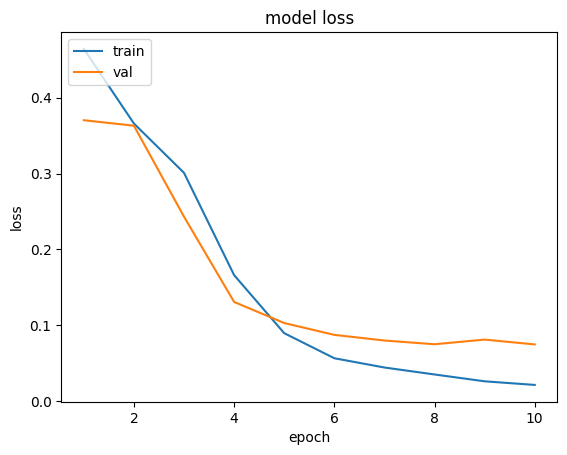

In [13]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 하이퍼파라미터 정의
embedding_dim = 32
dropout_ratio = 0.3
num_filters = 32
kernel_size = 5

# 모델 생성
model = Sequential()
model.add(Embedding(len(word_to_index) + 1, embedding_dim))  # 임베딩 층
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu')) # 1D Conv 층
model.add(GlobalMaxPooling1D()) # Max pooling 층
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

# 모델 요약 출력
model.summary()

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# 조기 종료 및 모델 체크포인트 콜백 정의
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 모델 학습
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[es, mc])

# 학습 및 검증 손실 시각화
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [14]:
# 테스트 정확도 출력
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test_padded, y_test)[1]))

33/33 [==============================] - 0s 4ms/step - loss: 0.0695 - acc: 0.9816

 테스트 정확도: 0.9816
